In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
# Load the data.
with np.load("ML4SCI_GSoC/QMLHEP/qcnn/electron-photon.npz") as data:
    train_examples = data['x_train'].reshape(-1, 32, 32, 1)
    train_labels = data['y_train']
    test_examples = data['x_test'].reshape(-1, 32, 32, 1)
    test_labels = data['y_test']

In [3]:
# Crop the image to make the calculations more feasible.
x_train_crop = train_examples[:, 15:19, 14:18, :]
x_test_crop = test_examples[:, 15:19, 14:18, :]
print(x_train_crop.shape)
print(x_test_crop.shape)

(100, 4, 4, 1)
(100, 4, 4, 1)


In [4]:
# Encode the values in a circuit by rotating the qubits by pixel values
def convert_to_circuit(image):
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_crop]
x_test_circ = [convert_to_circuit(x) for x in x_test_crop]

In [5]:
# Convert the circuits to tensors for use with TensorFlow Quantum
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [6]:
# Create a cluster state circuit.
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

In [8]:
# Convolution operation can be achived using parameterised unitaries or random parameterised circuits.
def one_qubit_unitary(bit, symbols):
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

In [9]:
# Create a circuit for performing a convolution operation.
def quantum_conv_circuit(bits, symbols):
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

In [10]:
# Create a circuit for peforming a pooling operation.
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

In [11]:
# Create a circuit using the above circuits. To achieve 3 sets of convolutions and pooling operations.
def create_model_circuit(qubits):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')
    
    
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]],
                                          symbols[57:63])
    return model_circuit


cluster_state_bits = cirq.GridQubit.rect(4, 4)
readout_operators = cirq.Z(cluster_state_bits[-1])

# Convert the model circuit to a Keras model so that it can be trained.
excitation_input = tf.keras.Input(
                                  shape=(),
                                  dtype=tf.dtypes.string
                                  )
cluster_state = tfq.layers.AddCircuit()(
                                        excitation_input, 
                                        prepend=cluster_state_circuit(cluster_state_bits)
                                        )

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits), readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [12]:
# Compile the model for binary classification.
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.02),
                   loss=tf.losses.binary_crossentropy,
                   metrics='accuracy')

history = qcnn_model.fit(x=x_train_tfcirc, y=train_labels, batch_size=16, epochs=25, validation_data=(x_train_tfcirc, test_labels))

Epoch 1/25
7/7 [==============================] - 3s 476ms/step - loss: 2.7855 - accuracy: 0.4400 - val_loss: 1.3676 - val_accuracy: 0.5400
Epoch 2/25
7/7 [==============================] - 3s 452ms/step - loss: 1.6641 - accuracy: 0.4400 - val_loss: 1.1344 - val_accuracy: 0.5400
Epoch 3/25
7/7 [==============================] - 3s 462ms/step - loss: 1.3086 - accuracy: 0.4400 - val_loss: 1.3065 - val_accuracy: 0.5400
Epoch 4/25
7/7 [==============================] - 3s 470ms/step - loss: 1.6251 - accuracy: 0.4400 - val_loss: 1.3198 - val_accuracy: 0.5400
Epoch 5/25
7/7 [==============================] - 3s 450ms/step - loss: 1.5702 - accuracy: 0.4400 - val_loss: 0.9831 - val_accuracy: 0.5400
Epoch 6/25
7/7 [==============================] - 3s 451ms/step - loss: 1.5096 - accuracy: 0.4400 - val_loss: 1.2661 - val_accuracy: 0.5400
Epoch 7/25
7/7 [==============================] - 3s 471ms/step - loss: 1.4670 - accuracy: 0.4400 - val_loss: 1.1251 - val_accuracy: 0.5400
Epoch 8/25
7/7 [====

In [13]:
# Create a smaller circuit for hybrid model.
readouts = [cirq.Z(bit) for bit in cluster_state_bits[4:]]
def multi_readout_model_circuit(qubits):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    return model_circuit

In [14]:
# Use the above circuit to create a Keras model with multiple convolution and pooling layers.
excitation_input_multi = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_multi = tfq.layers.AddCircuit()(
    excitation_input_multi, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model_multi1 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi2 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi3 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

# Concatenate the outputs and feed into a small classical dense network
concat_out = tf.keras.layers.concatenate(
    [quantum_model_multi1, quantum_model_multi2, quantum_model_multi3])

dense_1 = tf.keras.layers.Dense(8)(concat_out)

dense_2 = tf.keras.layers.Dense(1)(dense_1)

multi_qconv_model = tf.keras.Model(inputs=[excitation_input_multi],
                                   outputs=[dense_2])

In [15]:
# Compile and train the model.
multi_qconv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

hhistory = multi_qconv_model.fit(x=x_train_tfcirc, y=train_labels, batch_size=16, epochs=25, validation_data=(x_train_tfcirc, test_labels))

Epoch 1/25
7/7 [==============================] - 2s 352ms/step - loss: 1.2440 - accuracy: 0.5000 - val_loss: 0.7048 - val_accuracy: 0.5400
Epoch 2/25
7/7 [==============================] - 2s 315ms/step - loss: 0.7420 - accuracy: 0.4700 - val_loss: 0.7243 - val_accuracy: 0.4400
Epoch 3/25
7/7 [==============================] - 2s 310ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.7251 - val_accuracy: 0.4600
Epoch 4/25
7/7 [==============================] - 2s 312ms/step - loss: 0.6926 - accuracy: 0.5600 - val_loss: 0.6952 - val_accuracy: 0.4400
Epoch 5/25
7/7 [==============================] - 2s 302ms/step - loss: 0.7292 - accuracy: 0.5000 - val_loss: 0.6970 - val_accuracy: 0.4400
Epoch 6/25
7/7 [==============================] - 2s 298ms/step - loss: 0.6830 - accuracy: 0.5600 - val_loss: 0.7602 - val_accuracy: 0.4600
Epoch 7/25
7/7 [==============================] - 2s 318ms/step - loss: 0.6917 - accuracy: 0.5600 - val_loss: 0.7150 - val_accuracy: 0.4600
Epoch 8/25
7/7 [====

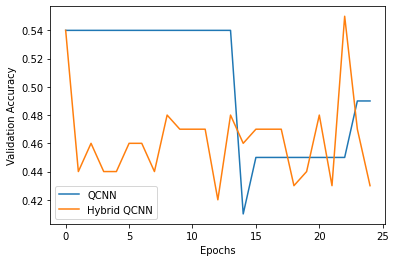

In [16]:
# Plot the comparative accuracies of both models.
plt.plot(history.history['val_accuracy'], label='QCNN')
plt.plot(hhistory.history['val_accuracy'], label='Hybrid QCNN')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()